## Random Forest Model for Fair Value Estimation

In [17]:
# Baseline RF model
RF_model = RandomForestRegressor(n_estimators=350, max_depth=2, max_features=4, max_leaf_nodes=4,
                                 min_samples_leaf=1, min_samples_split=6, random_state=random_state)
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
raw_1['datadate'] = raw_1['datadate'].astype('str')
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]
df_RF_Quintile_Signal = pd.DataFrame(index=list_company)
df_RF_Decile_Signal = pd.DataFrame(index=list_company)
df_RF_20_Divided_Signal = pd.DataFrame(index=list_company)
df_RF_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_train = X[X.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]

    X_test = X[X.datadate == test_date]
    X_test = X_test.iloc[:, 2:]

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]

    RF_fit = RF_model.fit(X_train, y_train)
    y_fair = RF_fit.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_RF_Quintile_Signal = df_RF_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_RF_Decile_Signal = df_RF_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_RF_Percentile_Signal = df_RF_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [18]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_RF_Quintile_Signal = pd.concat([df_199804_199809, df_RF_Quintile_Signal, df_202206], axis=1)
df_RF_Quintile_Signal = df_RF_Quintile_Signal.fillna(0).T
df_RF_Quintile_Signal = df_RF_Quintile_Signal.shift(1).dropna()

df_RF_Decile_Signal = pd.concat([df_199804_199809, df_RF_Decile_Signal, df_202206], axis=1)
df_RF_Decile_Signal = df_RF_Decile_Signal.fillna(0).T
df_RF_Decile_Signal = df_RF_Decile_Signal.shift(1).dropna()

df_RF_20_Divided_Signal = pd.concat([df_199804_199809, df_RF_20_Divided_Signal, df_202206], axis=1)
df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.fillna(0).T
df_RF_20_Divided_Signal = df_RF_20_Divided_Signal.shift(1).dropna()

df_RF_Percentile_Signal = pd.concat([df_199804_199809, df_RF_Percentile_Signal, df_202206], axis=1)
df_RF_Percentile_Signal = df_RF_Percentile_Signal.fillna(0).T
df_RF_Percentile_Signal = df_RF_Percentile_Signal.shift(1).dropna()

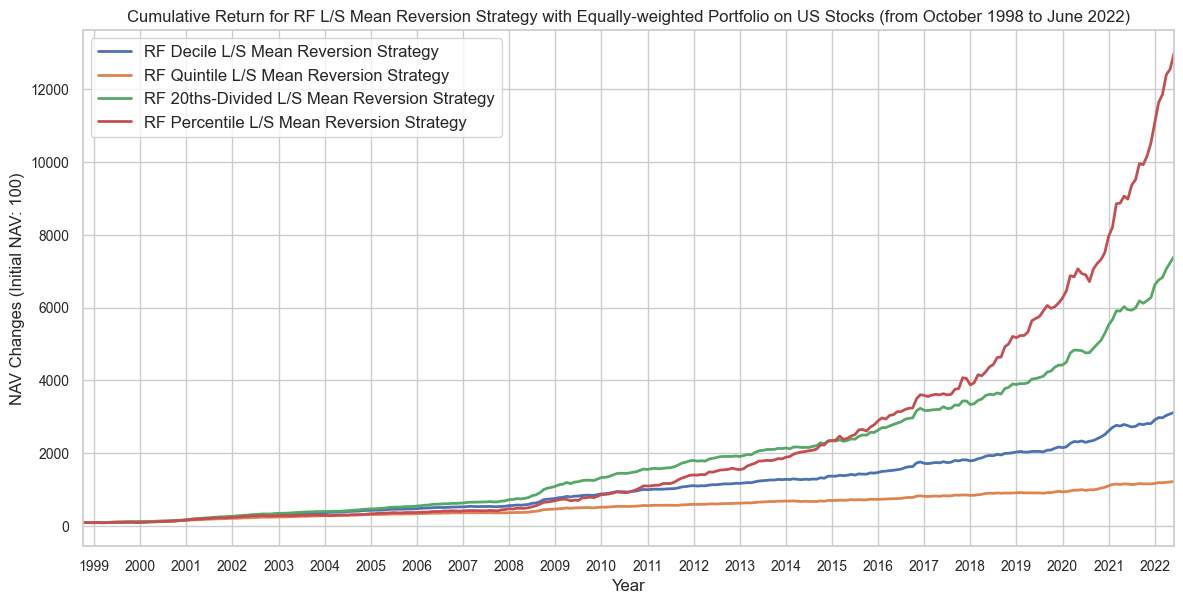

In [19]:
cum_RF_Q_strategy_return = get_price_df(df_RF_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_RF_D_strategy_return = get_price_df(df_RF_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_RF_T_strategy_return = get_price_df(df_RF_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_RF_P_strategy_return = get_price_df(df_RF_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_RF_strategy_return = pd.concat([cum_RF_D_strategy_return.rename('RF Decile L/S Mean Reversion Strategy'),
                                    cum_RF_Q_strategy_return.rename('RF Quintile L/S Mean Reversion Strategy'),
                                    cum_RF_T_strategy_return.rename('RF 20ths-Divided L/S Mean Reversion Strategy'),
                                    cum_RF_P_strategy_return.rename('RF Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_RF_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for RF L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [20]:
# Performance Stats
stats_RF_Q = get_performance_stats(cum_RF_Q_strategy_return, rfr=risk_free_rate_df, label='RF Quintile (Initial NAV: 100)')
stats_RF_D = get_performance_stats(cum_RF_D_strategy_return, rfr=risk_free_rate_df, label='RF Decile (Initial NAV: 100)')
stats_RF_T = get_performance_stats(cum_RF_T_strategy_return, rfr=risk_free_rate_df, label='RF 20ths (Initial NAV: 100)')
stats_RF_P = get_performance_stats(cum_RF_P_strategy_return, rfr=risk_free_rate_df, label='RF Percentile (Initial NAV: 100)')
RF_stats = pd.concat([stats_RF_Q, stats_RF_D, stats_RF_T, stats_RF_P], axis=0)
display(RF_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
RF Quintile (Initial NAV: 100),11.252236,0.111270,0.018682,0.047048,1.967934,0.716797,0.960605,1225.223567,2022-06-30,0.020860,2020-06-30,2020-07-31,2020-10-31,123
RF Decile (Initial NAV: 100),30.244258,0.155946,0.018682,0.055447,2.475584,0.984646,1.989696,3124.425833,2022-06-30,0.024444,2021-05-31,2021-07-31,2021-09-30,122
RF 20ths (Initial NAV: 100),73.017932,0.198696,0.018682,0.066709,2.698478,0.842081,2.527196,7401.793210,2022-06-30,0.028851,2017-12-31,2018-01-31,2018-03-31,90
RF Percentile (Initial NAV: 100),128.742045,0.227360,0.018682,0.091623,2.277567,0.061671,0.657140,12974.204476,2022-06-30,0.049916,2020-05-31,2020-08-31,2020-10-31,153


In [21]:
stats2_RF_Q = get_performance_stats_2(df_RF_Quintile_Signal, df_returns, df_market_cap, label='RF Quintile', model_type='ML')
stats2_RF_D = get_performance_stats_2(df_RF_Decile_Signal, df_returns, df_market_cap, label='RF Decile', model_type='ML')
stats2_RF_T = get_performance_stats_2(df_RF_20_Divided_Signal, df_returns, df_market_cap, label='RF 20ths', model_type='ML')
stats2_RF_P = get_performance_stats_2(df_RF_Percentile_Signal, df_returns, df_market_cap, label='RF Percentile', model_type='ML')
RF_stats2 = pd.concat([stats2_RF_Q, stats2_RF_D, stats2_RF_T, stats2_RF_P], axis=0)
display(RF_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
RF Quintile (Long & Short),11.252236,0.008831,3.688582e+10,0.731034,0.090477,-0.075939,0.507497,0.523216,0.494267,213.262069
(Long Position),1204.797880,0.025207,6.247204e+08,0.706897,0.102489,-0.073133,0.569532,0.590882,0.551840,137.737931
(Short Position),-0.935349,-0.009564,7.031321e+10,0.382759,0.062939,-0.069032,0.450596,0.462146,0.440734,75.793103
RF Decile (Long & Short),30.244258,0.012150,6.208299e+10,0.762069,0.090811,-0.072009,0.519891,0.540890,0.502375,163.975862
(Long Position),8379.901362,0.032205,5.379736e+08,0.748276,0.103559,-0.065121,0.596164,0.629704,0.568914,109.437931
(Short Position),-0.938749,-0.009751,1.160745e+11,0.379310,0.062361,-0.068729,0.453448,0.465573,0.443098,54.589655
RF 20ths (Long & Short),73.017932,0.015217,1.040810e+11,0.796552,0.091657,-0.069669,0.536930,0.559545,0.518074,114.427586
(Long Position),50266.556444,0.038713,5.348494e+08,0.834483,0.103248,-0.055444,0.634860,0.674220,0.602963,79.903448
(Short Position),-0.944764,-0.010110,1.898131e+11,0.382759,0.064055,-0.070930,0.456903,0.468439,0.447060,34.551724
RF Percentile (Long & Short),128.742045,0.017219,3.020776e+11,0.741379,0.093552,-0.075550,0.580099,0.570994,0.588270,36.337931


In [50]:
cum_RF_Q_strategy_return_L = get_price_df(df_RF_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_RF_Q_strategy_return_S = get_price_df(df_RF_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_RF_D_strategy_return_L = get_price_df(df_RF_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_RF_D_strategy_return_S = get_price_df(df_RF_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_RF_Q_L = get_performance_stats(cum_RF_Q_strategy_return_L, rfr=risk_free_rate_df, label='RF Quintile L (Initial NAV: 100)')
stats_RF_Q_S = get_performance_stats(cum_RF_Q_strategy_return_S, rfr=risk_free_rate_df, label='RF Quintile S (Initial NAV: 100)')
stats_RF_D_L = get_performance_stats(cum_RF_D_strategy_return_L, rfr=risk_free_rate_df, label='RF Decile L (Initial NAV: 100)')
stats_RF_D_S = get_performance_stats(cum_RF_D_strategy_return_S, rfr=risk_free_rate_df, label='RF Decile S (Initial NAV: 100)')
RF_stats3 = pd.concat([stats_RF_Q_L, stats_RF_Q_S, stats_RF_D_L, stats_RF_D_S], axis=0)
display(RF_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
RF Quintile L (Initial NAV: 100),1204.797880,0.348149,0.018682,0.164392,2.004149,0.244120,0.344610,137572.231823,2021-10-31,0.123517,2021-10-31,2022-06-30,Yet to recover,Yet to recover
RF Quintile S (Initial NAV: 100),6.949611,0.091212,0.018682,0.165032,0.439490,-0.527994,1.224726,1017.725332,2021-10-31,0.218884,2021-10-31,2022-06-30,Yet to recover,Yet to recover
RF Decile L (Initial NAV: 100),8379.901362,0.462821,0.018682,0.150825,2.944721,0.494051,0.477331,898808.527952,2022-03-31,0.067554,2022-03-31,2022-06-30,Yet to recover,Yet to recover
RF Decile S (Initial NAV: 100),7.024074,0.091641,0.018682,0.170520,0.427859,-0.405262,1.558873,1080.982467,2021-08-31,0.257705,2021-08-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [ ]:
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]

validation_date = ['1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09']
X_validation = X[X.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]

RF_param_grid =  {'n_estimators': [300, 350],
                   'min_samples_split': [4, 5, 6],
                   'min_samples_leaf': [1, 2],
                   'max_leaf_nodes': [3, 4, 5],
                   'max_features':[4, 5],
                   'max_depth':[2]}

RF_model = RandomForestRegressor(random_state=random_state)
grid_mse = GridSearchCV(estimator=RF_model, param_grid=RF_param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_mse.fit(X_validation, y_validation)

In [ ]:
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [ ]:
"""
{'max_depth': 2, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 350}
"""

### (3) Feature Importance

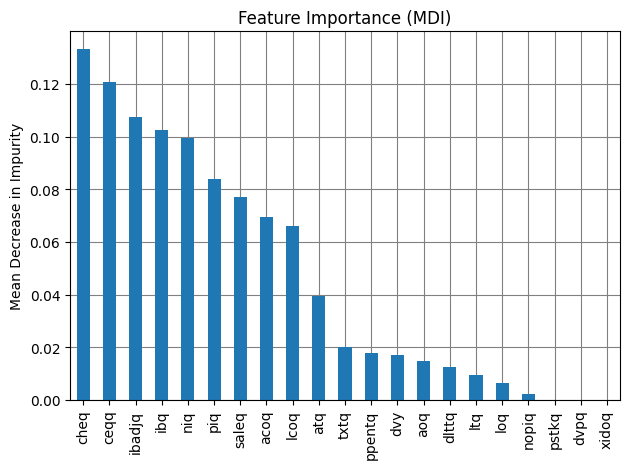

In [256]:
RF_importances = RF_model.feature_importances_
RF_importances_1 = pd.Series(RF_importances, index=feature_names).sort_values(ascending=False)

fig, ax1 = plt.subplots()
RF_importances_1.plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance (MDI)')
ax1.set_ylabel('Mean Decrease in Impurity')
fig.tight_layout()
plt.show()